In [1]:
from functools import reduce
from os import path

from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from qso.utils import WAVEMIN, WAVEMAX
from qso import sdss

In [2]:
SDSS_DIR = path.join("data", "sdss")
SDSS_DR14 = path.join(SDSS_DIR, "sdss_dr14")
SDSS_CATALOG = path.join(SDSS_DIR, "specObj-dr14.fits")
SDSS_QSO_CATALOG = path.join(SDSS_DIR, "DR14Q_v4_4.fits")
SDSS_HDF5 = path.join(SDSS_DIR, "sdss_dr14.hdf5")
SDSS_SELECTED_CATALOG = path.join(SDSS_DIR, "sdss_dr14_selected.csv")

# SDSS DR14 Optical Spectra Catalog

According to [data model](https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html)
contains the list of all spectra for a given data release,
with associated parameters from the 2D and 1D pipelines for each.

In [3]:
catalog_hdul = fits.open(SDSS_CATALOG)
catalog_hdul.info()

catalog = catalog_hdul[1].data
n_spec = catalog.shape[0]

Filename: data/sdss/specObj-dr14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    283   4851200R x 133C   [6A, 4A, 16A, 27A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 20A, I, 4A, 7A, 7A, J, D, D, D, E, E, 22A, 8A, K, J, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, 6A, 21A, E, E, J, J, A, 5E, 5E]   


In [4]:
catalog["plate"].dtype, catalog["mjd"].dtype, catalog["fiberid"].dtype

(dtype('>i4'), dtype('>i4'), dtype('>i4'))

In [5]:
multiindex = pd.MultiIndex.from_arrays(
    [catalog["plate"].astype("i4"), catalog["mjd"].astype("i4"), catalog["fiberid"].astype("i4")],
    names=["plate", "mjd", "fiberid"]
)

catalog_df = pd.DataFrame(
    data={
        "platequality": pd.Categorical(catalog["platequality"]),
        "targettype": pd.Categorical(catalog["targettype"]),
        "wavemax": catalog["wavemax"].astype("f4"),
        "wavemin": catalog["wavemin"].astype("f4"),
        "zwarning": catalog["zwarning"].astype("i4"),
    },
    index=multiindex
).sort_index()

catalog_df.info()
catalog_df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851200 entries, (266, 51602, 1) to (10000, 57346, 1000)
Data columns (total 5 columns):
platequality    category
targettype      category
wavemax         float32
wavemin         float32
zwarning        int32
dtypes: category(2), float32(2), int32(1)
memory usage: 92.6 MB


platequality targettype       wavemax      wavemin  \
plate mjd   fiberid                                                      
266   51602 1           bad        SCIENCE    9202.376953  3806.273682   
            2           bad        SCIENCE    9202.376953  3806.273682   
            3           bad        SCIENCE    9202.376953  3806.273682   
            4           bad        SCIENCE    9202.376953  3806.273682   
            5           bad        SCIENCE    9202.376953  3805.397217   
...                          ...        ...           ...          ...   
10000 57346 996         good       SCIENCE   10360.959961  3617.428955   
            997         good       SCIENCE   10360.959961  3617.428955   
            998         good       STANDARD  10360.959961  3617.428955   
            999         good       SCIENCE   10360.959961  3617.428955   
            1000        good       SCIENCE   10360.959961  3616.595947   

                     zwarning  
plate mjd   fiberid            
266   51602 1               0  
            2               0  
            3               0  
            4               0  
            5               0  
...                       ...  
10000 57346 996             4  
            997             4  
            998             0  
            999             0  
            1000            0  

[4851200 rows x 5 columns]

In [6]:
catalog_df.loc[catalog_df["wavemax"] == 0.0, "wavemax"] = np.nan
catalog_df.loc[catalog_df["wavemin"] == 0.0, "wavemin"] = np.nan

In [7]:
zwarning = catalog_df["zwarning"].values

catalog_df["unplugged"] = False
catalog_df["nodata"] = False

# https://www.sdss.org/dr13/algorithms/bitmasks/#ZWARNING
unplugged_idx = np.bitwise_and(zwarning, 2 ** 7).astype("bool")
nodata_idx = np.bitwise_and(zwarning, 2 ** 9).astype("bool")

catalog_df.loc[unplugged_idx, "unplugged"] = True
catalog_df.loc[nodata_idx, "nodata"] = True

In [8]:
catalog_df

platequality targettype       wavemax      wavemin  \
plate mjd   fiberid                                                      
266   51602 1           bad        SCIENCE    9202.376953  3806.273682   
            2           bad        SCIENCE    9202.376953  3806.273682   
            3           bad        SCIENCE    9202.376953  3806.273682   
            4           bad        SCIENCE    9202.376953  3806.273682   
            5           bad        SCIENCE    9202.376953  3805.397217   
...                          ...        ...           ...          ...   
10000 57346 996         good       SCIENCE   10360.959961  3617.428955   
            997         good       SCIENCE   10360.959961  3617.428955   
            998         good       STANDARD  10360.959961  3617.428955   
            999         good       SCIENCE   10360.959961  3617.428955   
            1000        good       SCIENCE   10360.959961  3616.595947   

                     zwarning  unplugged  nodata  
plate mjd   fiberid                               
266   51602 1               0      False   False  
            2               0      False   False  
            3               0      False   False  
            4               0      False   False  
            5               0      False   False  
...                       ...        ...     ...  
10000 57346 996             4      False   False  
            997             4      False   False  
            998             0      False   False  
            999             0      False   False  
            1000            0      False   False  

[4851200 rows x 7 columns]

In [9]:
catalog_hdul.close()

# SDSS DR14 Quasar Catalog

Known problems of the catalog are listed in a Jupyter notebook
[Preparing SDSS DR14 VACs](https://github.com/noaodatalab/digestor/blob/master/docs/notebooks/Preparing_SDSS_DR14_VACs.ipynb)
where VACs value added catalogs.

In [10]:
qso_hdul = fits.open(SDSS_QSO_CATALOG)
qso_hdul.info()

columns = qso_hdul[1].columns
qso_catalog = qso_hdul[1].data

Filename: data/sdss/DR14Q_v4_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_4    1 BinTableHDU    328   526356R x 105C   [18A, D, D, J, I, J, I, 4A, D, D, 4A, D, D, D, I, D, D, D, K, K, K, K, K, K, I, I, I, 51J, 51J, 51J, 51A, D, D, I, A, I, I, A, 5D, 5D, 5D, 5D, D, 5D, D, D, D, D, D, D, D, D, D, D, D, E, D, D, D, D, D, D, E, I, D, D, E, I, D, D, E, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 4A, 4A, D, E, D, D, D, D, D, D, D, D, I, D, D, D]   


In [11]:
n_primary = qso_catalog.shape[0]
n_additional = qso_catalog["n_spec"].sum()
n_primary, n_additional, n_primary + n_additional

(526356, 123435, 649791)

In [12]:
def get_duplicate_spec(duplicate):
    return duplicate[duplicate > 0]

plate_duplicate   = get_duplicate_spec(qso_catalog["plate_duplicate"])
mjd_duplicate     = get_duplicate_spec(qso_catalog["mjd_duplicate"])
fiberid_duplicate = get_duplicate_spec(qso_catalog["fiberid_duplicate"])

plate_duplicate.shape, mjd_duplicate.shape, fiberid_duplicate.shape

((103156,), (103156,), (103156,))

In [13]:
n_true_additional = plate_duplicate.shape[0]
n_qso = n_primary + n_true_additional
n_true_additional, n_qso

(103156, 629512)

In [14]:
qso_catalog["plate"].dtype, qso_catalog["mjd"].dtype, qso_catalog["fiberid"].dtype

(dtype('>i2'), dtype('>i4'), dtype('>i2'))

In [15]:
def fill_array(arr, primaries, duplicates, n_primary=n_primary):
    arr[:n_primary] = primaries
    arr[n_primary:] = duplicates


plate   = np.zeros(shape=n_qso, dtype='i2')
mjd     = np.zeros(shape=n_qso, dtype='i4')
fiberid = np.zeros(shape=n_qso, dtype='i2')

fill_array(plate, qso_catalog["plate"], plate_duplicate)
fill_array(mjd, qso_catalog["mjd"], mjd_duplicate)
fill_array(fiberid, qso_catalog["fiberid"], fiberid_duplicate)

In [16]:
qso_hdul.close()

# Combining

In [17]:
qso_multiindex = pd.MultiIndex.from_arrays(
    [plate, mjd, fiberid],
    names=["plate", "mjd", "fiberid"]
)

qso_missing = qso_multiindex.difference(multiindex)

qso_multiindex = qso_multiindex.difference(qso_missing)
qso_multiindex.shape

(629457,)

In [18]:
qso_missing.shape, qso_missing

((55,), MultiIndex([(2516, 54240,  21),
             (2516, 54240,  64),
             (2516, 54240,  93),
             (2516, 54240,  98),
             (2516, 54240,  99),
             (2516, 54240, 119),
             (2516, 54240, 122),
             (2516, 54240, 125),
             (2516, 54240, 157),
             (2516, 54240, 165),
             (2516, 54240, 188),
             (2516, 54240, 196),
             (2516, 54240, 197),
             (2516, 54240, 201),
             (2516, 54240, 213),
             (2516, 54240, 218),
             (2516, 54240, 250),
             (2516, 54240, 289),
             (2516, 54240, 303),
             (2516, 54240, 330),
             (2516, 54240, 342),
             (2516, 54240, 346),
             (2516, 54240, 362),
             (2516, 54240, 369),
             (2516, 54240, 394),
             (2516, 54240, 407),
             (2516, 54240, 419),
             (2516, 54240, 424),
             (2516, 54240, 467),
             (2516, 54240, 472),
   

In [19]:
catalog_df["qso"] = False
catalog_df.loc[qso_multiindex, "qso"] = True

In [20]:
catalog_df

platequality targettype       wavemax      wavemin  \
plate mjd   fiberid                                                      
266   51602 1           bad        SCIENCE    9202.376953  3806.273682   
            2           bad        SCIENCE    9202.376953  3806.273682   
            3           bad        SCIENCE    9202.376953  3806.273682   
            4           bad        SCIENCE    9202.376953  3806.273682   
            5           bad        SCIENCE    9202.376953  3805.397217   
...                          ...        ...           ...          ...   
10000 57346 996         good       SCIENCE   10360.959961  3617.428955   
            997         good       SCIENCE   10360.959961  3617.428955   
            998         good       STANDARD  10360.959961  3617.428955   
            999         good       SCIENCE   10360.959961  3617.428955   
            1000        good       SCIENCE   10360.959961  3616.595947   

                     zwarning  unplugged  nodata    qso  
plate mjd   fiberid                                      
266   51602 1               0      False   False  False  
            2               0      False   False  False  
            3               0      False   False  False  
            4               0      False   False  False  
            5               0      False   False  False  
...                       ...        ...     ...    ...  
10000 57346 996             4      False   False  False  
            997             4      False   False  False  
            998             0      False   False  False  
            999             0      False   False   True  
            1000            0      False   False  False  

[4851200 rows x 8 columns]

# Analysis

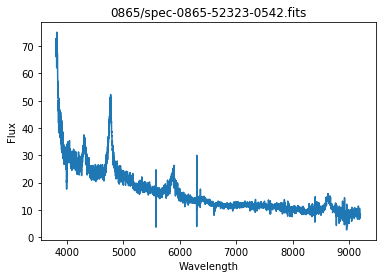

In [21]:
def plot_spec(plate, mjd, fiberid):
    dr_path = sdss.get_dr_path(plate, mjd, fiberid)
    filepath = path.join(SDSS_DR14, dr_path)
    with fits.open(filepath) as hdul:
        data = hdul[1].data
        ax = plt.axes(xlabel="Wavelength", ylabel="Flux", title=dr_path)
        ax.plot(np.power(10, data["loglam"]), data["flux"])

qso = catalog_df[catalog_df["qso"]].sample()
plot_spec(*qso.index[0])

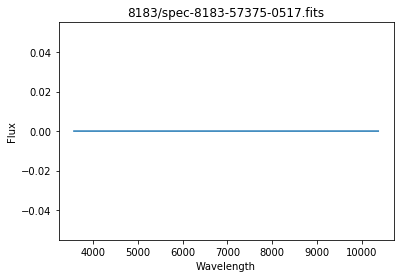

In [22]:
nodata_spec = catalog_df[catalog_df["nodata"]].sample()
plot_spec(*nodata_spec.index[0])

In [23]:
catalog_df.groupby("qso")["nodata"].value_counts()

qso    nodata
False  False     4212749
       True         8994
True   False      628969
       True          488
Name: nodata, dtype: int64

In [24]:
np.all(catalog_df["wavemin"].isna() == catalog_df["wavemax"].isna())

True

In [25]:
catalog_df[catalog_df["unplugged"] & catalog_df["wavemax"].notna()].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4315 entries, (270, 51909, 102) to (10000, 57346, 717)
Data columns (total 8 columns):
platequality    4315 non-null category
targettype      4315 non-null category
wavemax         4315 non-null float32
wavemin         4315 non-null float32
zwarning        4315 non-null int32
unplugged       4315 non-null bool
nodata          4315 non-null bool
qso             4315 non-null bool
dtypes: bool(3), category(2), float32(2), int32(1)
memory usage: 164.1 KB


In [26]:
catalog_df[catalog_df["nodata"]].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9482 entries, (3589, 55186, 184) to (10000, 57346, 993)
Data columns (total 8 columns):
platequality    9482 non-null category
targettype      9482 non-null category
wavemax         0 non-null float32
wavemin         0 non-null float32
zwarning        9482 non-null int32
unplugged       9482 non-null bool
nodata          9482 non-null bool
qso             9482 non-null bool
dtypes: bool(3), category(2), float32(2), int32(1)
memory usage: 280.2 KB


In [27]:
catalog_df.groupby("qso")["unplugged"].value_counts()

qso    unplugged
False  False        4203660
       True           18083
True   False         628775
       True             682
Name: unplugged, dtype: int64

In [28]:
catalog_df.groupby("qso")["targettype"].value_counts()

qso    targettype
False  SCIENCE       3738730
       SKY            394231
       STANDARD        88782
True   SCIENCE        629451
       STANDARD            6
Name: targettype, dtype: int64

In [29]:
catalog_df.groupby("qso")["platequality"].value_counts()

qso    platequality
False  good            3763636
       marginal         384713
       bad               73394
True   good             598604
       marginal          30007
       bad                 846
Name: platequality, dtype: int64

qso
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: wavemin, dtype: object

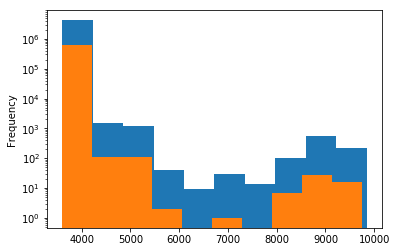

In [30]:
catalog_df.groupby("qso")["wavemin"].plot.hist(log=True)

qso
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: wavemax, dtype: object

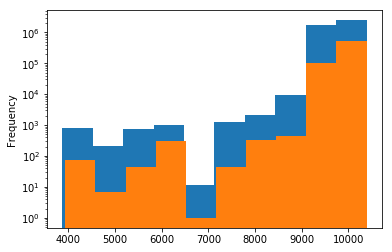

In [31]:
catalog_df.groupby("qso")["wavemax"].plot.hist(log=True)

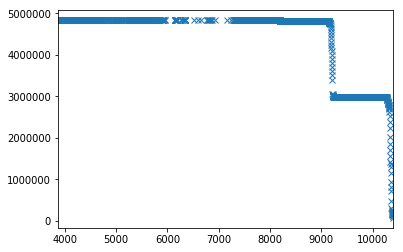

In [32]:
ax = catalog_df["wavemax"].value_counts().sort_index(ascending=False).cumsum().plot(style="x")
ax.axvline(WAVEMAX, color="k")

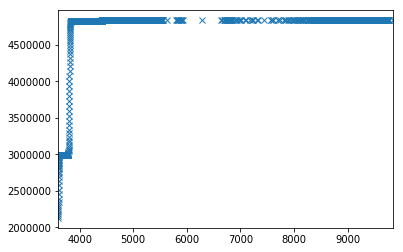

In [33]:
ax = catalog_df["wavemin"].value_counts().sort_index().cumsum().plot(style="x")
ax.axvline(WAVEMIN, color="k")

In [34]:
# wavelengths from `lamost_analysis.ipynb`
idx_selected = (catalog_df["wavemin"] <= 3839.7244) & (8914.597 <= catalog_df["wavemax"])
n_selected = idx_selected.sum()

n_selected, n_spec - n_selected

(4816713, 34487)

In [35]:
catalog_df["qso"].sum() - catalog_df.loc[idx_selected, "qso"].sum()

1949

In [36]:
catalog_selected_df = catalog_df[idx_selected]
catalog_selected_df.to_csv(path.join(SDSS_DIR, "sdss_dr14_selected.csv"))
catalog_selected_df.shape, catalog_df.shape

((4816713, 8), (4851200, 8))